<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Емельянов Георгий (@georguy), студент 4 курса СПБГУАП

# <center> Convolution Neural Networks. Traffic Signs Recognition </center>

В этом туториале речь пойдет про распознавание дорожных знаков с использованием сверточных нейронных сетей.
В сети можно легко найти материалы по сверточным нейронным сетям, поэтому здесь не будет большого количества теории и описания библиотеки TensorFlow, с помощью которой мы и будем сегодня строить сеть. В конце статьи находится список полезной литературы, который поможет глубже узнать сверточные нейронные сети.

## СNN

Особенностью сверточных нейронных сетей является наличие так называемых сверточных слоев, которые выполняют операцию свертки. Выражение «свернуть изображение» означает, что необходимо пространственно пробежать по изображению и вычислить скалярные произведения.
	Каждый сверточный слой передаёт в новый слой так называемые карты признаков, которые и являются результатами скалярного произведения.
	Эти карты признаков поступают на вход субдискретизирующих слоёв, задача которых состоит в уменьшении размерность карт признаков.
	Для уменьшения размерности часто используют одну из двух функций: max pooling, average pooling. Первая функция выбирает максимальное значение уменьшаемого участка карты признаков. Вторая функция выбирает уже среднее значение. Таким образом находится признак, наличие которого является наиболее ключевым фактором отнесения классифицируемого изображение к одному из классов.

## Сразу в бой
Не будем раскачиваться на теории, а сразу возьмемся за практику. По [ссылке](https://drive.google.com/file/d/0ByDNm-bvLJQEN2xtTHo4STgyMkE/view?usp=sharing) вы можете скачать тренировочные и тестовые наборы картинок в усеченном и расширенном объеме. В туториале используется усеченная выборка для экономии времени - в тренировочной выборке содержится всего 11100 изображений(в то время как в расширенном - 473000).

Для построения модели, обучения и тестирования используется Tensorflow версии 0.12.1.

Приступим.

In [1]:
# Импортируем все необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pickle
import sys
import time
import numpy as np
import matplotlib
from pandas.io.parsers import read_csv
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import tensorflow as tf

In [2]:
# Функция для загрузки dataset'ов
def load_pickled_data(file, columns):
    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    return tuple(map(lambda c: dataset[c], columns))

# Функция для подсчета времени- понадобится при логировании времени обучения
def get_time_hhmmss(start = None):
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

Посмотрим на тренировочный и тестовый наборы данных

In [3]:
train_dataset_path = "../../../data/german-traffic-signs/truncated/original/train.p"
test_dataset_path = "../../../data/german-traffic-signs/truncated/original/test.p"

X_train, Y_train = load_pickled_data(train_dataset_path, ['features', 
                                                          'labels'])
X_test, Y_test = load_pickled_data(test_dataset_path, ['features',
                                                       'labels'])
n_train = len(Y_train)
n_test = len(Y_test)
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(Y_train, return_index=True, return_counts=True)
n_classes = len(class_counts)
print("Число тренировочных изображений =", n_train)
print("Число тестовых изображений =", n_test)
print("Shape изображений =", image_shape)
print("Число классов =", n_classes)

Число тренировочных изображений = 11100
Число тестовых изображений = 3660
Shape изображений = (32, 32, 3)
Число классов = 6


Класс 0: Ограничение максимальной скорости (30км/ч) 2220 изображений


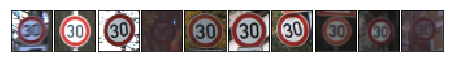

Класс 1: Ограничение максимальной скорости (50км/ч) 2250 изображений


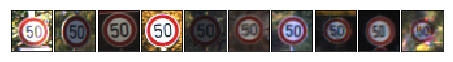

Класс 2: Главная дорога                             2100 изображений


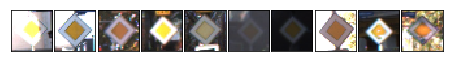

Класс 3: Уступите дорогу                            2160 изображений


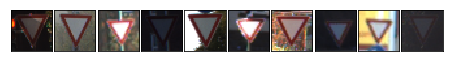

Класс 4: Объезд препятствия справа                  2070 изображений


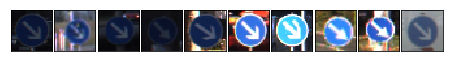

Класс 5: Объезд препятствия слева                   300 изображений


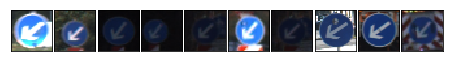

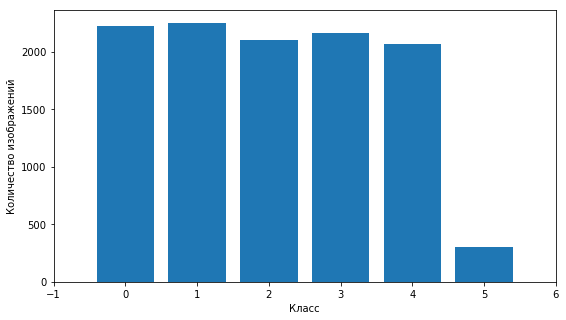

In [4]:
import random
signnames = read_csv("../../../data/german-traffic-signs/truncated/signnames.csv").values[:, 1]

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Класс %i: %-*s %s изображений" %(c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    
fig = pyplot.figure(figsize = (9, 5))

pyplot.bar( np.arange( n_classes ), class_counts, align='center' )
pyplot.xlabel('Класс')
pyplot.ylabel('Количество изображений')
pyplot.xlim([-1, n_classes])
pyplot.show()

В тренировочной выборке присутствуют 6 классов дорожных знаков, изображения в 5 из которых распределены примерно равномерно, за исключением 6-го класса, в котором всего лишь 300 объектов. 

Видим, что изображения цветные – содержат три канала. Но наша модель будет распознавать изображения заранее обработанные – лишь с одним каналом.

Исходные изображения находятся в цветовом пространстве RGB. Удобным способом снижения размерности является преобразование исходного цветного изображения в черно-белое изображение с помощью компоненты яркости Y. Y – одна из составляющих цветового пространства YCbCr.

Обработанные данные уже содержатся в скачанном архиве, поэтому обработкой заниматься вам не придется.

In [5]:
train_preprocessed_dataset_path = "../../../data/german-traffic-signs/truncated/preprocessed/train_preprocessed.p"
test_preprocessed_dataset_path = "../../../data/german-traffic-signs/truncated/preprocessed/test_preprocessed.p"

X_train_preprocessed, Y_train_preprocessed = load_pickled_data(train_preprocessed_dataset_path, ['features', 
                                                                                                 'labels'])
X_test_preprocessed, Y_test_preprocessed = load_pickled_data(test_preprocessed_dataset_path, ['features',
                                                                                              'labels'])
image_shape = X_train_preprocessed[0].shape
image_size = image_shape[0]
print("Shape изображений =", image_shape)

Shape изображений = (32, 32, 1)


Класс 0: Ограничение максимальной скорости (30км/ч) 2220 изображений


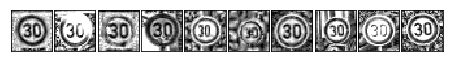

Класс 1: Ограничение максимальной скорости (50км/ч) 2250 изображений


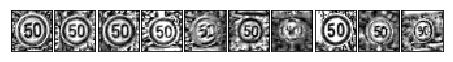

Класс 2: Главная дорога                             2100 изображений


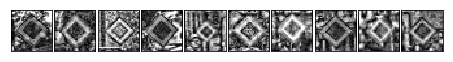

Класс 3: Уступите дорогу                            2160 изображений


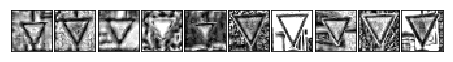

Класс 4: Объезд препятствия справа                  2070 изображений


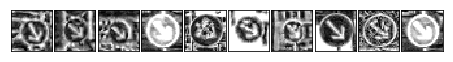

Класс 5: Объезд препятствия слева                   300 изображений


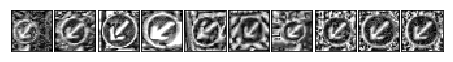

In [6]:
col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Класс %i: %-*s %s изображений" %(c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train_preprocessed[random_indices[i]].reshape(32, 32), cmap='gray')
    pyplot.show()

Архитектура нашей сети будет иметь следующий вид

<center>
<img src="../../img/model_architecture.png">
</center>

Первым делом давайте определим структуру для удобной организации параметров сети

In [7]:
from collections import namedtuple

# Структура для организации параметров модели
Parameters = namedtuple('Parameters', [
        # Данные об изображениях
        'num_classes', 'image_size', 
        # Параметры обучения
        'batch_size', 'max_epochs', 'log_epoch', 'print_epoch',
        # Оптимизации
        'learning_rate_decay', 'learning_rate',
        'l2_reg_enabled', 'l2_lambda', 
        'early_stopping_enabled', 'early_stopping_patience', 
        'resume_training', 
        # Архитектура слоёв
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'conv3_k', 'conv3_d', 'conv3_p', 
        'fc4_size', 'fc4_p'
    ])

Так же нам понадобится класс, с помощью которого мы сможем получить информацию о параметрах сети во время и после её обучения

In [8]:
import os

class Paths(object):
    def __init__(self, params):
        self.model_name = self.get_model_name(params)
        self.var_scope = self.get_variables_scope(params)
        self.root_path = os.getcwd() + "/models/" + self.model_name + "/"
        self.model_path = self.get_model_path()
        self.train_history_path = self.get_train_history_path()
        self.learning_curves_path = self.get_learning_curves_path()
        os.makedirs(self.root_path, exist_ok = True)
        
    def get_model_name(self, params):
        model_name = "k{}d{}p{}_k{}d{}p{}_k{}d{}p{}_fc{}p{}".format(
            params.conv1_k, params.conv1_d, params.conv1_p, 
            params.conv2_k, params.conv2_d, params.conv2_p, 
            params.conv3_k, params.conv3_d, params.conv3_p, 
            params.fc4_size, params.fc4_p
        )
        model_name += "_lrdec" if params.learning_rate_decay else "_no-lrdec"
        model_name += "_l2" if params.l2_reg_enabled else "_no-l2"
        return model_name
    
    def get_variables_scope(self, params):
        var_scope = "k{}d{}_k{}d{}_k{}d{}_fc{}_fc0".format(
            params.conv1_k, params.conv1_d,
            params.conv2_k, params.conv2_d,
            params.conv3_k, params.conv3_d, 
            params.fc4_size
        )
        return var_scope
    
    def get_model_path(self):
        return self.root_path + "model.ckpt"
    
    def get_train_history_path(self):
        return self.root_path + "train_history"
    
    def get_learning_curves_path(self):
        return self.root_path + "learning_curves.png"

Создадим класс EarlyStopping, который поможет избежать переобучения, а также поможет следить за лучшими результатами правильных ответов

In [9]:
class EarlyStopping(object):
    def __init__(self, saver, session, patience = 50, minimize = True):
        self.minimize = minimize
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_epoch = 0
        self.restore_path = None
        
    def __call__(self, value, epoch):
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

Определяем функцию для логирования этапов и состояния обучения

In [10]:
from cloudlog import CloudLog

class ModelCloudLog(CloudLog):
    
    def log_parameters(self, params, train_size, valid_size, test_size):
        if params.resume_training:
            self("===============================================")
            self("============= Продолжение обучения ============")
            self("===============================================")

        self("=================== Данные ====================")
        self("            Train dataset: {} изображений".format(train_size))
        self("          Valid dataset: {} изображений".format(valid_size))
        self("             Test dataset: {} изображений".format(test_size))
        self("              Batch size: {}".format(params.batch_size))   

        self("=================== Модель ===================")
        self("---------------- Архитектура -----------------")  
        self(" %-*s %-*s %-*s %-*s" % (10, "", 10, "Type", 8, "Size", 15, "Dropout (keep p)"))    
        self(" %-*s %-*s %-*s %-*s" % (10, "1 слой", 10, "{}x{} Conv".format(params.conv1_k, params.conv1_k), 8, str(params.conv1_d), 15, str(params.conv1_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "2 слой", 10, "{}x{} Conv".format(params.conv2_k, params.conv2_k), 8, str(params.conv2_d), 15, str(params.conv2_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "3 слой", 10, "{}x{} Conv".format(params.conv3_k, params.conv3_k), 8, str(params.conv3_d), 15, str(params.conv3_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "4 слой", 10, "FC", 8, str(params.fc4_size), 15, str(params.fc4_p)))    
        self("----------------- Параметры ------------------")
        self("     Learning rate: " + ("Enabled" if params.learning_rate_decay else "Disabled (rate = {})".format(params.learning_rate)))
        self("       L2 Regularization: " + ("Enabled (lambda = {})".format(params.l2_lambda) if params.l2_reg_enabled else "Disabled"))
        self("          Early stopping: " + ("Enabled (patience = {})".format(params.early_stopping_patience) if params.early_stopping_enabled else "Disabled"))
        self(" Keep training old model: " + ("Enabled" if params.resume_training else "Disabled"))

### Модель
Объявим вспомогательные функции-обертки над Tensorflow для каждого типа слоя

In [11]:
# Полносвязный слой
def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
                              shape = [input.get_shape()[1], size],
                              initializer = tf.contrib.layers.xavier_initializer()
                             )
    biases = tf.get_variable( 'biases',
                             shape = [size],
                             initializer = tf.constant_initializer(0.0)
                            )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    return tf.nn.relu(fully_connected(input, size))

# Сверточный слой
def conv_relu(input, kernel_size, depth):
    weights = tf.get_variable( 'weights', 
                              shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
                              initializer = tf.contrib.layers.xavier_initializer()
                             )
    biases = tf.get_variable( 'biases',
                             shape = [depth],
                             initializer = tf.constant_initializer(0.0)
                            )
    conv = tf.nn.conv2d( input,
                        weights,
                        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

# Субдискретизирующий слой
def pool(input, size):
    return tf.nn.max_pool( input, 
                          ksize = [1, size, size, 1], 
                          strides = [1, size, size, 1], 
                          padding = 'SAME'
                         )

# Построение архитектуры сети
def model_pass(input, params, is_training):

    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = params.conv1_k, depth = params.conv1_d) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        pool1 = tf.cond(is_training, lambda: tf.nn.dropout(pool1, keep_prob = params.conv1_p), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = params.conv2_k, depth = params.conv2_d)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        pool2 = tf.cond(is_training, lambda: tf.nn.dropout(pool2, keep_prob = params.conv2_p), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = params.conv3_k, depth = params.conv3_d)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        pool3 = tf.cond(is_training, lambda: tf.nn.dropout(pool3, keep_prob = params.conv3_p), lambda: pool3)
    
    pool1 = pool(pool1, size = 4)
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    pool2 = pool(pool2, size = 2)
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])    
    
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    flattened = tf.concat(1, [pool1, pool2, pool3])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = params.fc4_size)
        fc4 = tf.cond(is_training, lambda: tf.nn.dropout(fc4, keep_prob = params.fc4_p), lambda: fc4)
    with tf.variable_scope('out'):
        logits = fully_connected(fc4, size = params.num_classes)
    return logits

В конце обучения нам необходимо будет вывести график зависимости функции потерь (loss) и доли правильных ответов (accuracy) от номера эпохи. Поэтому определим для этого две функции, которые и будут заниматься отрисовкой.

In [12]:
def plot_curve(axis, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    model_history = np.load(Paths(params).train_history_path + ".npz")
    train_values = model_history[train_column]
    valid_values = model_history[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return epochs

def plot_learning_curves(params):
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_accuracy_history", valid_column = "valid_accuracy_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    pyplot.ylim(50., 115.)
    pyplot.xlim(0, epochs_plotted)

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_loss_history", valid_column = "valid_loss_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(0.0001, 10.)
    pyplot.xlim(0, epochs_plotted)
    pyplot.yscale("log")

Ну и наконец-то метод, который и будет инициировать процесс обучения и тестирования.

In [13]:
from nolearn.lasagne import BatchIterator

def train_model(params, X_train, y_train, X_valid, y_valid, X_test, y_test):
    paths = Paths(params)
    log = ModelCloudLog(os.path.join(paths.root_path, "logs"))
    start = time.time()
    model_variable_scope = paths.var_scope

    log.log_parameters(params, y_train.shape[0], y_valid.shape[0], y_test.shape[0]) 
    
    # Строим граф
    graph = tf.Graph()
    with graph.as_default():
        # Инициализируем входные данные
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, params.num_classes))
        is_training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0, trainable=False)

        if params.learning_rate_decay:
            learning_rate = tf.train.exponential_decay(params.learning_rate, current_epoch, decay_steps = params.max_epochs, decay_rate = 0.01)
        else:
            learning_rate = params.learning_rate
            
        with tf.variable_scope(model_variable_scope):
            logits = model_pass(tf_x_batch, params, is_training)
            if params.l2_reg_enabled:
                with tf.variable_scope('fc4', reuse = True):
                    l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))
            else:
                l2_loss = 0

        predictions = tf.nn.softmax(logits)
        softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, tf_y_batch)
        loss = tf.reduce_mean(softmax_cross_entropy) + params.l2_lambda * l2_loss  

        optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(loss)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        # Данная функция позволит оценивать текущие параметы модели, такие как accuracy и loss
        def get_accuracy_and_loss_in_batches(X, y):
            p = []
            sce = []
            batch_iterator = BatchIterator(batch_size = 128)
            for x_batch, y_batch in batch_iterator(X, y):
                [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : False
                    }
                )
                p.extend(p_batch)
                sce.extend(sce_batch)
            p = np.array(p)
            sce = np.array(sce)
            accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
            loss = np.mean(sce)
            return (accuracy, loss)
        
        # В случае, если мы захотим продолжить обучении ранее обученной модели, мы перезапустим сессию
        if params.resume_training: 
            try:
                tf.train.Saver().restore(session, paths.model_path)
            except Exception as e:
                log("Неудалось запустить обучение предобученной модели: файл не найден.")
                pass
        
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(tf.train.Saver(), session, patience = params.early_stopping_patience, minimize = True)
        train_loss_history = np.empty([0], dtype = np.float32)
        train_accuracy_history = np.empty([0], dtype = np.float32)
        valid_loss_history = np.empty([0], dtype = np.float32)
        valid_accuracy_history = np.empty([0], dtype = np.float32)
        if params.max_epochs > 0:
            log("================= Обучение ==================")
        else:
            log("=============== Тестирование ================")       
        log(" Timestamp: " + get_time_hhmmss())
        log.sync()
        
        for epoch in range(params.max_epochs):
            current_epoch = epoch
            batch_iterator = BatchIterator(batch_size = params.batch_size, shuffle = True)
            for x_batch, y_batch in batch_iterator(X_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            # Когда проходит эпоха, выводим логируем значения loss и accuracy для тестовой и валидационной выборки
            if (epoch % params.log_epoch == 0):
                valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
                train_accuracy, train_loss = get_accuracy_and_loss_in_batches(X_train, y_train)

                if (epoch % params.print_epoch == 0):
                    log("-------------- %4d/%d Эпоха --------------" % (epoch, params.max_epochs))
                    log("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                    log("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                    log("      Best loss: %.8f at epoch %d" % (early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                    log("   Elapsed time: " + get_time_hhmmss(start))
                    log("      Timestamp: " + get_time_hhmmss())
                    log.sync()
            else:
                valid_loss = 0.
                valid_accuracy = 0.
                train_loss = 0.
                train_accuracy = 0.
                
            valid_loss_history = np.append(valid_loss_history, [valid_loss])
            valid_accuracy_history = np.append(valid_accuracy_history, [valid_accuracy])
            train_loss_history = np.append(train_loss_history, [train_loss])
            train_accuracy_history = np.append(train_accuracy_history, [train_accuracy])
            
            if params.early_stopping_enabled:
                if valid_loss == 0:
                    _, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
                if early_stopping(valid_loss, epoch): 
                    log("Early stopping.\nНаименьшее значение функции потерь: {:.8f} на {} эпохе.".format(
                        early_stopping.best_monitored_value, early_stopping.best_monitored_epoch
                    ))
                    break

        # И тестируем модель на тестовой выборке
        test_accuracy, test_loss = get_accuracy_and_loss_in_batches(X_test, y_test)
        valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
        log("=============================================")
        log(" Valid loss: %.8f, accuracy = %.2f%%)" % (valid_loss, valid_accuracy)) 
        log(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
        log(" Total time: " + get_time_hhmmss(start))
        log("  Timestamp: " + get_time_hhmmss())

        # Сохраняем значения весов для использования в будущем
        saved_model_path = saver.save(session, paths.model_path)
        log("Файл модели: " + saved_model_path)
        np.savez(paths.train_history_path, train_loss_history = train_loss_history, train_accuracy_history = train_accuracy_history, valid_loss_history = valid_loss_history, valid_accuracy_history = valid_accuracy_history)
        log("Файл истории обучения: " + paths.train_history_path)
        log.sync(notify=True, message="Обучение окончено с *%.2f%%* accuracy на тестовой выборке (loss = *%.6f*)." % (test_accuracy, test_loss))
        
        plot_learning_curves(params)
        log.add_plot(notify=True, caption="Learning curves")
        
        pyplot.show()



/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


=================== Данные ====================
            Train dataset: 8325 изображений
          Valid dataset: 2775 изображений
             Test dataset: 3660 изображений
              Batch size: 256
=================== Модель ===================
---------------- Архитектура -----------------
            Type       Size     Dropout (keep p)
 1 слой     5x5 Conv   32       0.9            
 2 слой     5x5 Conv   64       0.8            
 3 слой     5x5 Conv   128      0.7            
 4 слой     FC         1024     0.5            
----------------- Параметры ------------------
     Learning rate: Enabled
       L2 Regularization: Enabled (lambda = 0.0001)
          Early stopping: Enabled (patience = 50)
 Keep training old model: Disabled
================= Обучение ==================
 Timestamp: 2017/05/27 17:12:52
--------------    0/60 Эпоха --------------
     Train loss: 1.48183060, accuracy: 67.71%
Validation loss: 1.49201894, accuracy: 65.95%
      Best loss: inf at epoch 0

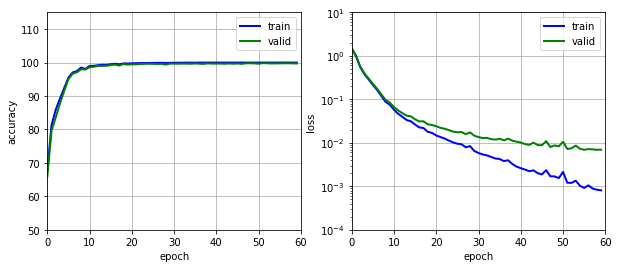

In [14]:
from sklearn.model_selection import train_test_split

parameters = Parameters(
    # Данные об изображениях
    num_classes = n_classes,
    image_size = (32, 32),
    # Параметры обучения
    batch_size = 256,
    max_epochs = 60,
    log_epoch = 1,
    print_epoch = 1,
    # Оптимизации
    learning_rate_decay = True,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 50,
    resume_training = False,
    # Архитектуры слоёв
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

X_train_preprocessed, X_valid_preprocessed, Y_train_preprocessed, Y_valid_preprocessed = train_test_split(X_train_preprocessed, 
                                                                                                          Y_train_preprocessed,
                                                                                                          test_size = 0.25)

train_model(parameters, 
            X_train_preprocessed, Y_train_preprocessed, 
            X_valid_preprocessed, Y_valid_preprocessed, 
            X_test_preprocessed,Y_test_preprocessed)

Время обучения на моей машине (mb pro, core i5, 8Gb, Intel Iris 1536 МБ) составило почти полтора часа. На полной выборке – 66 часов.
На тестовой выборке доля правильных ответов составила 99,21 % – приличный результат.

Давайте в конце еще посмотрим на изображения, которые сеть не смогла правильно классифицировать.

In [15]:
def get_top_k_predictions(params, X, k = 5):
    paths = Paths(params)
    
    graph = tf.Graph()
    with graph.as_default():
        tf_x = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        is_training = tf.constant(False)
        with tf.variable_scope(paths.var_scope):
            predictions = tf.nn.softmax(model_pass(tf_x, params, is_training))
            top_k_predictions = tf.nn.top_k(predictions, k)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        tf.train.Saver().restore(session, paths.model_path)
        [p] = session.run([top_k_predictions], feed_dict = {
                tf_x : X
            }
        )
        return np.array(p)

Кол-во неправильно распознанных изображений: 29
Оригинальные:


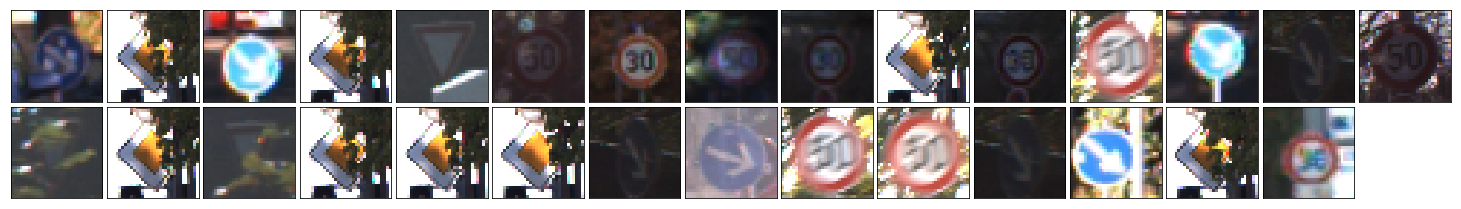

Обработанные:


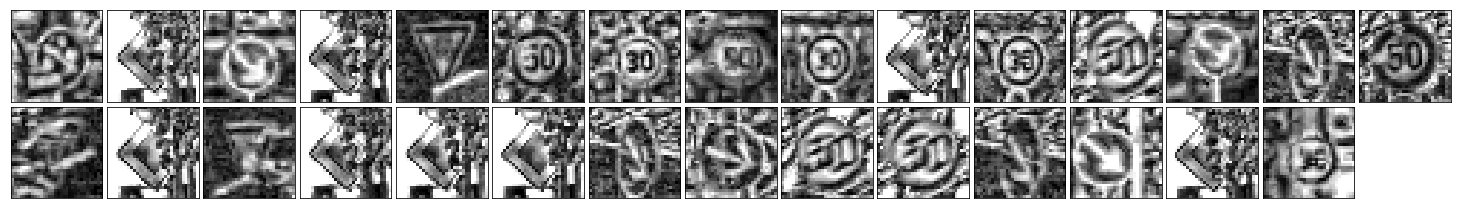

In [20]:
predictions = get_top_k_predictions(parameters, X_test_preprocessed)

predictions = predictions[1][:, np.argmax(predictions[0], 1)][:, 0].astype(int)
labels = np.argmax(Y_test_preprocessed, 1)

incorrectly_predicted = X_test[predictions != labels]
print("Кол-во неправильно распознанных изображений:", len(incorrectly_predicted))
print("Оригинальные:")
fig = pyplot.figure(figsize=(20, 20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(incorrectly_predicted.shape[0]):
    ax = fig.add_subplot(15, 15, i + 1, xticks=[], yticks=[])
    ax.imshow(incorrectly_predicted[i])
pyplot.show()

print("Обработанные:")
incorrectly_predicted = X_test_preprocessed[predictions != labels]
fig = pyplot.figure(figsize=(20, 20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(incorrectly_predicted.shape[0]):
    ax = fig.add_subplot(15, 15, i + 1, xticks=[], yticks=[])
    ax.imshow(incorrectly_predicted[i].reshape(32, 32), cmap='gray')
pyplot.show()

На этом всё. В этом туториале мы построили сверточную нейронную сеть для распознавания дорожных знаков, которая показала достаточно хорошие результаты классификации на не очень большой выборке данных, а также посмотрели на изображения, которые сеть не смогла распознать.
Спасибо за внимание.

## Полезные ссылки

- [Глава про СНН из книги Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks)
- [CS231n: Convolutional Neural Networks for Visual Recognition. ](http://cs231n.github.io/convolutional-networks/)
- [Статья Яна Лекуна о распознавании дорожных знаков](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)